In [1]:
#@title Code that will set everything working for that exercise. It's good to have a look on it, though.

%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

## The Dataset
  
As in the previous exercises, we will use the California Housing Dataset.

## Load the dataset

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Task 0: Normalize values

When building a model with multiple features, the values of each feature should cover roughly the same range.  Use the code from the previous exercise that converts each raw value to its Z-score.

In [3]:
train_df_means = train_df.mean(0)
train_df_stds = train_df.std(0)
train_df_norm = (train_df - train_df_means) / train_df_stds
test_df_norm = (test_df - train_df_means) / train_df_stds

## Represent data

The following code creates a feature layer containing three features, that we consider representative:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `my_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [4]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model as a baseline. 

Before creating a neural net, find a loss by running a simple linear regression model that uses the feature layer you just created. 


In [5]:
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

## Train the model!
Run the following code cell to invoke the the functions defined in the preceding code cell. (Ignore the warning messages.)

**Note:** Because we've scaled all the input data, **including the label**, the resulting loss values will be *much less* than previous models. 

**Note:** Depending on the version of TensorFlow, running this cell might generate WARNING messages. Please ignore these warnings. 

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 2ms/step - loss: 1.1162 - mean_squared_error: 1.1162
Epoch 2/15
17/17 [==============================] - 0s 2ms/step - loss: 0.7226 - mean_squared_error: 0.7226
Epoch 3/15
17/17 [==============================] - 0s 2ms/step - loss: 0.5278 - mean_squared_error: 0.5278
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4287 - mean_squared_error: 0.4287
Epoch 5/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3865 - mean_squared_error: 0.3865
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3625 - mean_squared_error: 0.3625
Epoch 7/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3648 - mean_squared_error: 0.3648
Epoch 8/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3575 - mean_squared_error: 0.3575
Epoch 9/15
17/17 [========

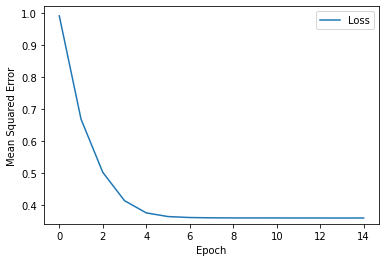


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 6ms/step - loss: 0.3784 - mean_squared_error: 0.3784


[0.37835827469825745, 0.37835827469825745]

In [6]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Now Define a neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of layers in the neural net.
* The number of nodes in each layer.

The `create_model` function also defines the activation function of each layer.

In [7]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

## Task 1: Describe the neural network architecture.

Focus the discussions on each layer. Make use of summary() function for the parameter topic. Discuss about hyperparameters of that layer and the chosen activation function.

Do not forget to describe the loss function and the metrics. Interpret those chosen options.



In [8]:
my_model = create_model(0.01, my_feature_layer)
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
_ = my_model.predict(test_features)
my_model.summary()

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
Hidden1 (Dense)              multiple                  2060      
_________________________________________________________________
Hidden2 (Dense)              multiple                  252       
_________________________________________________________________
Output (Dense)               multiple                  13        
Total params: 2,325
Trainable params: 2,325
Non-trainable params: 0
_________________________________________________________________


In [9]:
crossed_feature.variable_shape, population.variable_shape, median_income.variable_shape

(TensorShape([1, 100]), TensorShape([1]), TensorShape([1]))

A: As seen from the output of the previous cell, the model has a 'dense_features' layer, and 3 'dense' layers. The dense_features layer has no parameters (learnable), it instead does encoding and embedding of the features we provide. As we can see the features have shapes 100, 1 and 1. The input is thus (None, 102)


1.   Dense layer 1 takes input of shape (None, 102) and outputs (None, 20). Thus, it has a weight matrix of 32x784, while bias is a vector of size 32 (lenght of outputs). Thus, the total parameters in this layer are 20 x 102 + 20 -> 2060.
2.  Dense layer 2 takes input of shape (None, 20) and outputs (None, 12). Thus, it has a weight matrix of 12 x 20, while bias is a vector of size 10 (lenght of outputs). Thus, the total parameters in this layer are 12 x 20 + 12 ->1252.
3.  Dense layer 3 takes input of shape (None, 12) and outputs (None, 12). Thus, it has a weight matrix of 1 x 12, while bias is a vector of size 1 (lenght of outputs). Thus, the total parameters in this layer are 1 x 12 + 1 -> 13.

The loss function used is 'mean_squared_error' and the metrics are the same. 

## Function to train the network

The `train_model` function trains the model from the input features and labels. The `tf.keras.Model.fit` method performs the actual training. The `x` parameter of the `fit` method is very flexible, enabling you to pass feature data in a variety of ways. The following implementation passes a Python dictionary in which:

* The *keys* are the names of each feature (for example, `longitude`, `latitude`, and so on).
* The *value* of each key is a NumPy array containing the values of that feature. 

**Note:** Although you are passing *every* feature to `model.fit`, most of those values will be ignored. Only the features accessed by `my_feature_layer` will actually be used to train the model.

In [10]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

## Now build and train a neural net


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 6ms/step - loss: 0.8753 - mean_squared_error: 0.8753
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4009 - mean_squared_error: 0.4009
Epoch 3/20
17/17 [==============================] - 0s 8ms/step - loss: 0.3536 - mean_squared_error: 0.3536
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3335 - mean_squared_error: 0.3335
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.3413 - mean_squared_error: 0.3413
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3318 - mean_squared_error: 0.3318
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.3307 - mean_squared_error: 0.3307
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3227 - mean_squared_error: 0.3227
Epoch 9/20
17/17 [========

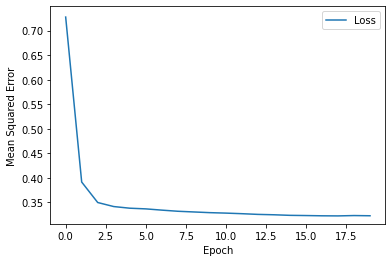


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 6ms/step - loss: 0.3465 - mean_squared_error: 0.3465


[0.34648388624191284, 0.34648388624191284]

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Task 2: Compare the two models

How did the deep neural net perform against the baseline linear regression model?

Thee deep neural net performed slightly better than the baseline.

## Task 3: Optimize the deep neural network's topography

Experiment with the number of layers of the deep neural network and the number of nodes in each layer.  Aim to achieve both of the following goals:

*  Lower the loss against the test set.
*  Minimize the overall number of nodes in the deep neural net. 

The two goals may be in conflict.

In [12]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  model.add(my_feature_layer)
  
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden1'))

  model.add(tf.keras.layers.Dense(units=64, 
                                  activation='relu', 
                                  name='Hidden2'))
  

  model.add(tf.keras.layers.Dense(units=32, 
                                  activation='relu', 
                                  name='Hidden3'))
  
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 10ms/step - loss: 0.6058 - mean_squared_error: 0.6058
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 0.3487 - mean_squared_error: 0.3487
Epoch 3/20
17/17 [==============================] - 0s 13ms/step - loss: 0.3368 - mean_squared_error: 0.3368
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 0.3430 - mean_squared_error: 0.3430
Epoch 5/20
17/17 [==============================] - 0s 11ms/step - loss: 0.3373 - mean_squared_error: 0.3373
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 0.3312 - mean_squared_error: 0.3312
Epoch 7/20
17/17 [==============================] - 0s 11ms/step - loss: 0.3307 - mean_squared_error: 0.3307
Epoch 8/20
17/17 [==============================] - 0s 9ms/step - loss: 0.3336 - mean_squared_error: 0.3336
Epoch 9/20
17/17 [===

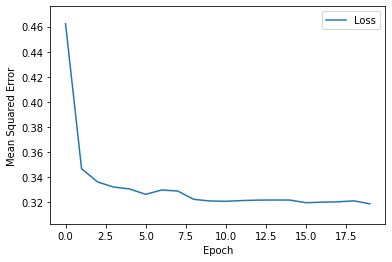


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 7ms/step - loss: 0.3456 - mean_squared_error: 0.3456


[0.34561413526535034, 0.34561413526535034]

In [13]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Task 4: Regularize the neural network

Notice that the model's loss against the test set is *much higher* than the loss against the training set. 

 In other words, the neural network is **overfitting** to the data in the training set.  
 
 To reduce overfitting, regularize the model. There are several different ways to regularize a model, including:

  * L1 regularization
  * L2 regularization
  * Dropout regularization

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (while still keeping test loss relatively low).  

**Note:** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

### **HINT** on Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to `tf.keras.layers.Dense`. Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the regularization rate. Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.05. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```

### **HINT** on Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography. For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to `tf.keras.layers.Dropout` specifies the fraction of nodes that the model should drop out during training. 


In [14]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  model.add(my_feature_layer)
  
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  model.add(tf.keras.layers.Dropout(rate=0.2))

  model.add(tf.keras.layers.Dense(units=64, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  model.add(tf.keras.layers.Dropout(rate=0.2))


  model.add(tf.keras.layers.Dense(units=32, 
                                  activation='relu', 
                                  name='Hidden3'))
  
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                               
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 2s 17ms/step - loss: 0.5831 - mean_squared_error: 0.5831
Epoch 2/50
17/17 [==============================] - 0s 16ms/step - loss: 0.3642 - mean_squared_error: 0.3642
Epoch 3/50
17/17 [==============================] - 0s 15ms/step - loss: 0.3535 - mean_squared_error: 0.3535
Epoch 4/50
17/17 [==============================] - 0s 16ms/step - loss: 0.3488 - mean_squared_error: 0.3488
Epoch 5/50
17/17 [==============================] - 0s 12ms/step - loss: 0.3463 - mean_squared_error: 0.3463
Epoch 6/50
17/17 [==============================] - 0s 14ms/step - loss: 0.3342 - mean_squared_error: 0.3342
Epoch 7/50
17/17 [==============================] - 0s 15ms/step - loss: 0.3382 - mean_squared_error: 0.3382
Epoch 8/50
17/17 [==============================] - 0s 18ms/step - loss: 0.3391 - mean_squared_error: 0.3391
Epoch 9/50
17/17 [

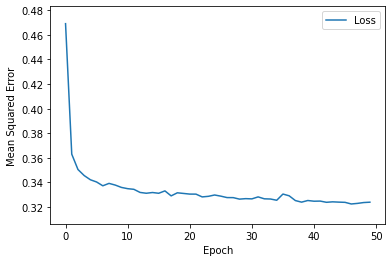


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 9ms/step - loss: 0.3502 - mean_squared_error: 0.3502


[0.3502330780029297, 0.3502330780029297]

In [15]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)